## solar cycle prediction for the 10.7 cm radio flux (SFU) and sunspot numbers (SSN) 

see these papers for the relationship between SFU and SSN:

Clette 2021:
https://www.swsc-journal.org/articles/swsc/pdf/2021/01/swsc200021.pdf

Tiwari and Kumar
https://journals.aijr.org/index.php/ias/article/view/751/172

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import urllib
import pandas as pd
data_path='data/'


#### load data from NOAA

In [2]:
#observations
noaa_url='https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json'
urllib.request.urlretrieve(noaa_url,data_path+'observed-solar-cycle-indices_2023_apr_19.json')

noaa_obs=pd.read_json(data_path+'observed-solar-cycle-indices_2023_apr_19.json')


#convert times to matplotlib format

noaa_obs_times=[]

#make datetime objects from file times
for i in np.arange(0,len(noaa_obs)): 
    year=int(noaa_obs['time-tag'][i][0:4])
    month=int(noaa_obs['time-tag'][i][5:7])
    
    noaa_obs_times.append(datetime.datetime(year,month,1))
   
noaa_obs_times_num=mdates.date2num(noaa_obs_times)

SSN_obs=noaa_obs['ssn']
SFU_obs=noaa_obs['f10.7']

noaa_obs

,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
0,1749-01,96.7,-1.0,-1.00,-1.0,-1.00,-1.0
1,1749-02,104.3,-1.0,-1.00,-1.0,-1.00,-1.0
2,1749-03,116.7,-1.0,-1.00,-1.0,-1.00,-1.0
3,1749-04,92.8,-1.0,-1.00,-1.0,-1.00,-1.0
4,1749-05,141.7,-1.0,-1.00,-1.0,-1.00,-1.0
...,...,...,...,...,...,...,...
3286,2022-11,80.5,-1.0,65.10,-1.0,123.56,-1.0
3287,2022-12,112.8,-1.0,110.03,-1.0,148.46,-1.0
3288,2023-01,143.6,-1.0,133.35,-1.0,182.47,-1.0
3289,2023-02,110.9,-1.0,126.75,-1.0,172.09,-1.0


#### figure out relationship for SSN to SFU

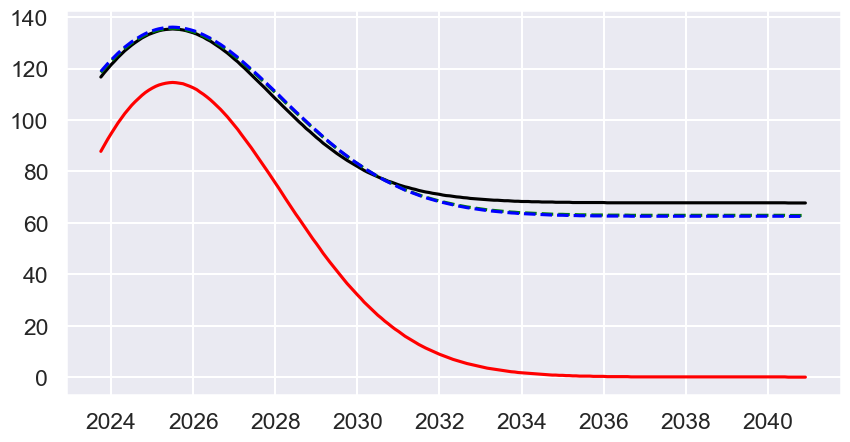

In [16]:
#define models to convert SSN to SFU
def tk_model(SSN_in):
    SFU_out = 62.51 + 0.6422*SSN_in
    return SFU_out

def clette_model(SSN_in):
    SFU_out = 62.87 + 0.6279*SSN_in +6.141*1e-5*SSN_in**2 #equation 2 in Clette 2021
    return SFU_out


###################### load the NOAA predicted data file from 2020
    
noaa_url='https://services.swpc.noaa.gov/json/solar-cycle/predicted-solar-cycle.json'
urllib.request.urlretrieve(noaa_url,data_path+'predicted-solar-cycle-2023_apr_19.json')
noaa_pred=pd.read_json(data_path+'predicted-solar-cycle-2023_apr_19.json')


#first few datapoints are weird, so I cut them off
noaa_pred=noaa_pred.drop(np.arange(0,12),axis=0)


noaa_pred_times=[]



#make datetime objects from file times
for i in np.arange(12,len(noaa_pred)+12): 
    year=int(noaa_pred['time-tag'][i][0:4])
    month=int(noaa_pred['time-tag'][i][5:7])
    noaa_pred_times.append(datetime.datetime(year,month,1))
    
#noaa_pred

noaa_pred_ssn=noaa_pred['predicted_ssn']
noaa_pred_sfu=noaa_pred['predicted_f10.7']

SFU_pred=np.array(noaa_pred_sfu)
SSN_pred=np.array(noaa_pred_ssn)



#NOAA model
#SFU_NOAA_1=67.00 + 0.4903*SSN < SSN 50
#SFU_NOAA_2=56.06 + 0.7092*SSN > SSN 50

#Johnson 
#SFU_J=60.72 + 0.900*SSN

#Tiwari Kumar 2018 model2
#SFU_TK2=65.6605 + 0.500687*SSN + 1.21647*1e-3*SSN**2- 2.71853*1e-6*SSN**3



sns.set_context('talk')
sns.set_style('darkgrid')
fig=plt.figure(1,figsize=(10,5),dpi=100)

plt.plot(noaa_pred_times,SSN_pred,'r')
plt.plot(noaa_pred_times,SFU_pred,'k')
plt.plot(noaa_pred_times,clette_model(SSN_pred),'g--')
plt.plot(noaa_pred_times,tk_model(SSN_pred),'b--')

### define Hathaway function for SSN from McIntosh+ 2022

In [17]:
def hathaway(x,x0, a, b, c):
    #Hathaway 2015 equation 6 page 40
    #average cycle sunspot number 
    #4 free parameters A, b, c, t0

    x1=(mdates.date2num(x)-mdates.date2num(x0))/30.42
    
    hatfunc=a*(((x1)/b)**3) * 1/(np.exp((((x1)/b)**2))-c)
        
    return hatfunc

#create an array with 1 day resolution between start and end
start_25=datetime.datetime(2020,6,1)
end_25=datetime.datetime(2033,1,1)
times_25_daily = [ start_25 + datetime.timedelta(days=n) for n in range(int ((end_25 - start_25).days))]  

#this sets the solar cycle 25 start time
sc_25_start_time=datetime.datetime(2020,1,1)

a=363
#aerr68=38 #MC20: 325 -> 170 max, 
b=60
c=0.8 
print('Hathaway function parameters')
print('a,b,c:', a,b,c)

#create daily SSN prediction 
SSN_mc_prediction=hathaway(times_25_daily, sc_25_start_time,a,b,c)

print('Maximum SSN in McIntosh 2022 forecast:', int(np.max(SSN_mc_prediction)))


##make SFU based on SSN prediction

SFU_mc_prediction_1= tk_model(SSN_mc_prediction)
SFU_mc_prediction_2= clette_model(SSN_mc_prediction)

print()
print('maximum SFU based on McIntosh forecast with TK and Clette models')
print(int(np.max(SFU_mc_prediction_1)))
print(int(np.max(SFU_mc_prediction_2)))


Hathaway function parameters
a,b,c: 363 60 0.8
Maximum SSN in McIntosh 2022 forecast: 189

maximum SFU based on McIntosh forecast with TK and Clette models
184
184


Text(0.5, 1.0, 'monthly averaged solar flux units number for McIntosh 2022 forecast')

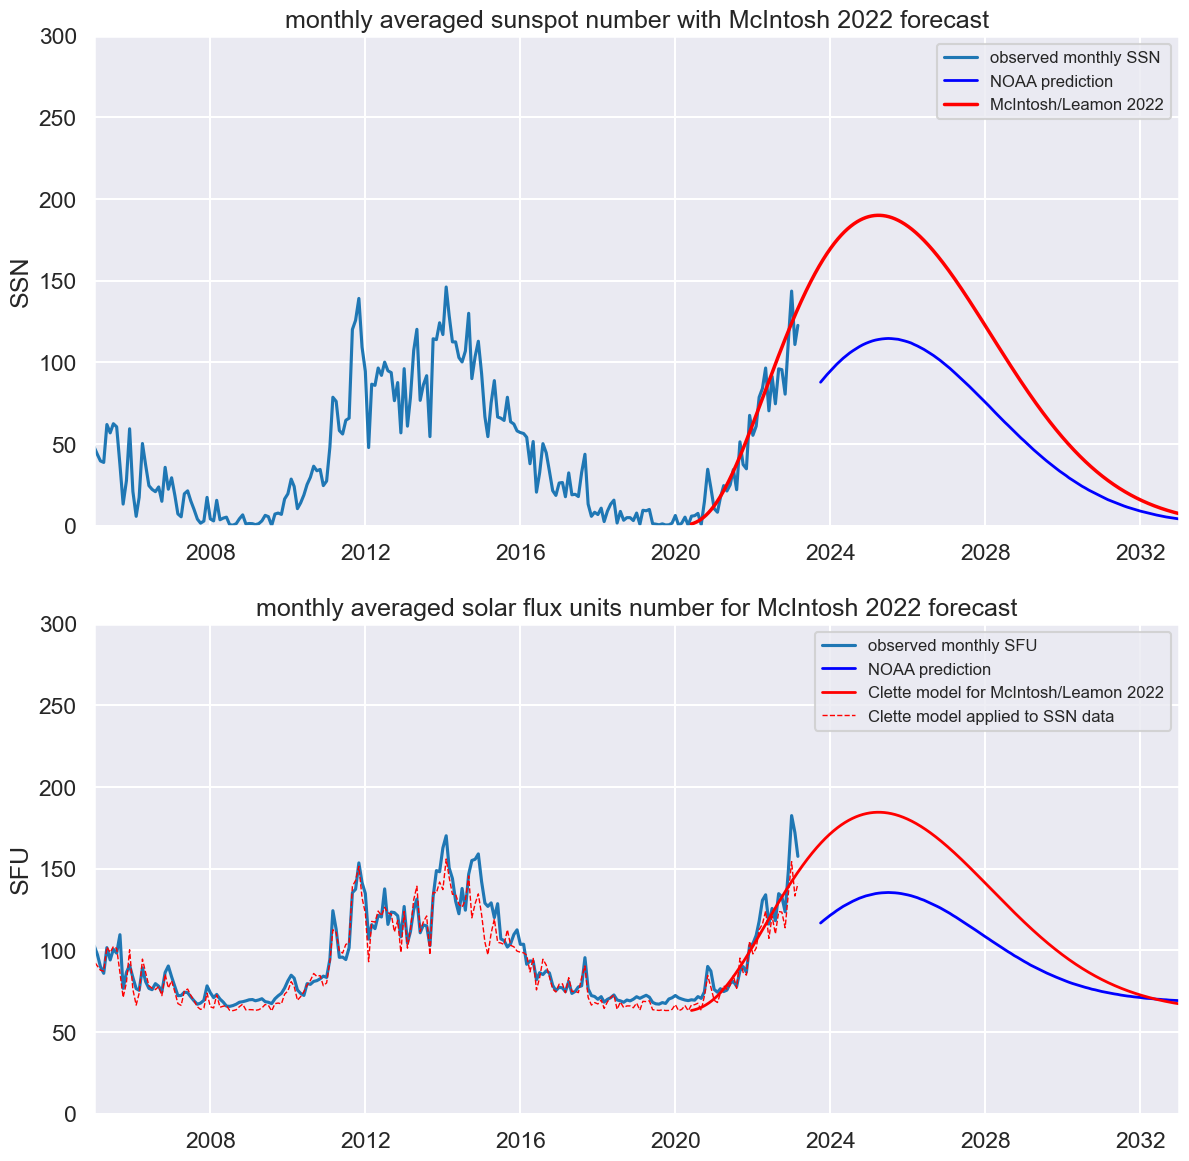

In [21]:
sns.set_context('talk')
sns.set_style('darkgrid')
fig=plt.figure(1,figsize=(14,14),dpi=100)

ax1 = plt.subplot(211) 
ax1.plot_date(noaa_obs_times,SSN_obs,'-', label='observed monthly SSN')

#predictions
ax1.plot(noaa_pred_times,SSN_pred,'b-',lw=2,label='NOAA prediction')
ax1.plot(times_25_daily,SSN_mc_prediction,'-r',alpha=1,linewidth=2.5,label='McIntosh/Leamon 2022')


ax1.set_xlim(datetime.datetime(2005,1,1),datetime.datetime(2033,1,1))
ax1.set_ylabel('SSN')
ax1.set_ylim(0,300)
ax1.legend(fontsize=12)
ax1.set_title('monthly averaged sunspot number with McIntosh 2022 forecast')



ax2 = plt.subplot(212) 
ax2.plot(noaa_obs_times,SFU_obs,'-',label='observed monthly SFU')

#predictions
ax2.plot(noaa_pred_times,SFU_pred,'b-',lw=2,label='NOAA prediction')
ax2.plot(times_25_daily,SFU_mc_prediction_1,'r-',alpha=1,linewidth=2,label='Clette model for McIntosh/Leamon 2022')

#ax2.plot(times_25_daily,SFU_mc_prediction_2,'k-',alpha=1,linewidth=1,label='TK model for McIntosh/Leamon 2022')
#ax2.plot(noaa_obs_times,tk_model(SSN_obs),'k--',lw=1, label='TK model')

ax2.plot(noaa_obs_times,clette_model(SSN_obs),'r--',lw=1,label='Clette model applied to SSN data')

ax2.set_xlim(datetime.datetime(2005,1,1),datetime.datetime(2033,1,1))
ax2.set_ylim(0,300)
ax2.set_ylabel('SFU')

ax2.legend(fontsize=12)

ax2.set_title('monthly averaged solar flux units number for McIntosh 2022 forecast')
